# 🌾 Crop Data Exploratory Data Analysis
---
**Objective:** Perform exploratory data analysis (EDA) on agricultural crop data to uncover
patterns, correlations, and actionable insights for fertilizer recommendations.

**Pipeline:**
1. Load and validate dataset structure
2. Statistical profiling (`.info()`, `.describe()`)
3. Visual analysis: distributions, correlations, outliers, etc.
4. Statistical Tests: Correlation, T-tests, ANOVA, etc.
5. ML Readiness Checks: Missing values, class balance, etc.
6. Summarize key findings

## ═══════════════════════════════════════════════════════════════════════════════
## SETUP: Imports & Configuration
## ═══════════════════════════════════════════════════════════════════════════════

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from pathlib import Path
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
import warnings
import os

warnings.filterwarnings('ignore')

# ── Plot Output Directory ─────────────────────────────────────────────────────
PLOT_DIR = Path("plots")
PLOT_DIR.mkdir(exist_ok=True)
print(f"✓ Plot output directory: {PLOT_DIR.resolve()}")

# ── Visual Configuration ──────────────────────────────────────────────────────
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({
    'figure.figsize': (12, 7),
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.labelsize': 11,
    'font.family': 'sans-serif',
    'axes.spines.top': False,
    'axes.spines.right': False,
})

# Color palette: Earth tones for agricultural theme
PALETTE = ['#2E4A3F', '#5C8A56', '#8FBC8F', '#C9A959', '#D4A574', '#8B7355', '#6B4423']
sns.set_palette(PALETTE)

print("✓ Libraries loaded successfully")

✓ Plot output directory: C:\Users\NOBEL\GitHub\AgroSense\notebooks\plots
✓ Libraries loaded successfully


## ═══════════════════════════════════════════════════════════════════════════════
## DATA LOADING: Load crop_data.csv
## ═══════════════════════════════════════════════════════════════════════════════

In [24]:
# Notebook is running from: AgroSense/notebooks
BASE_DIR = Path.cwd().parent   # go to AgroSense

DATA_PATH = BASE_DIR / "data" / "raw" / "crop_data.csv"

if not DATA_PATH.is_file():
    raise FileNotFoundError(f"Dataset not found at: {DATA_PATH.resolve()}")

df = pd.read_csv(DATA_PATH)

print(f"✓ Loaded: {DATA_PATH.resolve()} | Shape: {df.shape}")
df.head()



✓ Loaded: C:\Users\NOBEL\GitHub\AgroSense\data\raw\crop_data.csv | Shape: (8000, 9)


,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,26.0,52.0,38.0,Sandy,Maize,37,0,0,Urea
1,29.0,52.0,45.0,Loamy,Sugarcane,12,0,36,DAP
2,34.0,65.0,62.0,Black,Cotton,7,9,30,14-35-14
3,32.0,62.0,34.0,Red,Tobacco,22,0,20,28-28
4,28.0,54.0,46.0,Clayey,Paddy,35,0,0,Urea


## ═══════════════════════════════════════════════════════════════════════════════
## STATISTICAL PROFILING: Structure & Summary Statistics
## ═══════════════════════════════════════════════════════════════════════════════

In [25]:
print("=" * 70)
print("DATASET STRUCTURE (.info())")
print("=" * 70)
df.info()

DATASET STRUCTURE (.info())
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Temparature      8000 non-null   float64
 1   Humidity         8000 non-null   float64
 2   Moisture         8000 non-null   float64
 3   Soil Type        8000 non-null   object 
 4   Crop Type        8000 non-null   object 
 5   Nitrogen         8000 non-null   int64  
 6   Potassium        8000 non-null   int64  
 7   Phosphorous      8000 non-null   int64  
 8   Fertilizer Name  8000 non-null   object 
dtypes: float64(3), int64(3), object(3)
memory usage: 562.6+ KB


In [26]:
print("\n" + "=" * 70)
print("DESCRIPTIVE STATISTICS (.describe())")
print("=" * 70)
print(df.describe().round(2).to_string())

# ── Missing Values Check ──────────────────────────────────────────────────────
print("\n" + "=" * 70)
print("MISSING VALUES AUDIT")
print("=" * 70)
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Count': missing, 'Percent (%)': missing_pct})
print(missing_df[missing_df['Count'] > 0].to_string() if missing.sum() > 0 else "✓ No missing values detected")

# ── Categorical Cardinality ───────────────────────────────────────────────────
print("\n" + "=" * 70)
print("CATEGORICAL FEATURE CARDINALITY")
print("=" * 70)
cat_cols = df.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    print(f"  {col}: {df[col].nunique()} unique | Top: {df[col].mode()[0]}")


DESCRIPTIVE STATISTICS (.describe())
       Temparature  Humidity  Moisture  Nitrogen  Potassium  Phosphorous
count      8000.00   8000.00   8000.00   8000.00    8000.00      8000.00
mean         30.34     59.21     43.58     18.43       3.92        18.51
std           4.48      8.18     12.60     11.85       5.49        13.24
min          20.00     40.02     20.00      0.00       0.00         0.00
25%          27.05     53.28     33.97      9.00       0.00         8.00
50%          30.24     59.11     42.25     14.00       1.00        18.00
75%          33.46     65.08     52.95     26.00       5.00        30.00
max          40.00     80.00     70.00     46.00      23.00        46.00

MISSING VALUES AUDIT
✓ No missing values detected

CATEGORICAL FEATURE CARDINALITY
  Soil Type: 5 unique | Top: Clayey
  Crop Type: 11 unique | Top: Sugarcane
  Fertilizer Name: 7 unique | Top: 14-35-14


## ═══════════════════════════════════════════════════════════════════════════════
## VISUALIZATION
## ═══════════════════════════════════════════════════════════════════════════════

### 1: Target Distribution (Fertilizer Name)

✓ Saved: plots\01_target_distribution.png


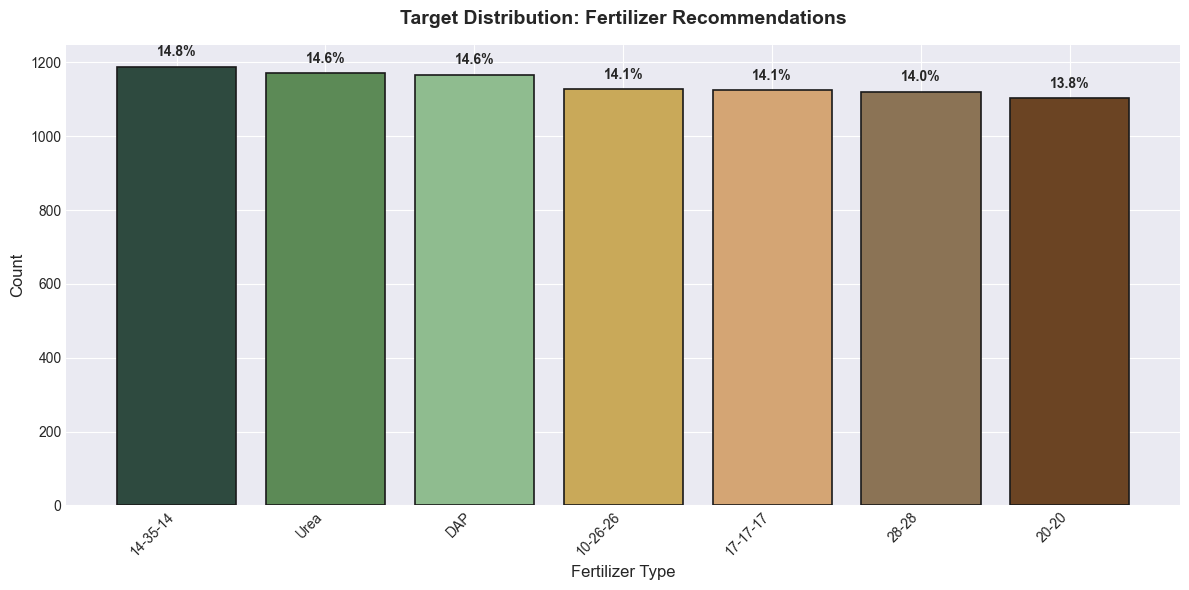

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))

# Assuming 'Fertilizer Name' is the target variable
target_col = 'Fertilizer Name'
if target_col in df.columns:
    order = df[target_col].value_counts().index
    counts = df[target_col].value_counts()

    bars = ax.bar(order, counts, color=PALETTE[:len(order)], edgecolor='#1a1a1a', linewidth=1.2)

    # Add percentage labels
    total = len(df)
    for bar, count in zip(bars, counts):
        pct = (count / total) * 100
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
                f'{pct:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax.set_xlabel('Fertilizer Type', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('Target Distribution: Fertilizer Recommendations', fontsize=14, fontweight='bold', pad=15)
    plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig(PLOT_DIR / '01_target_distribution.png', dpi=150, bbox_inches='tight', facecolor='white')
print(f"✓ Saved: {PLOT_DIR / '01_target_distribution.png'}")
plt.show()

### 2: Correlation Heatmap (Numeric Features)


✓ Saved: plots\02_correlation_heatmap.png


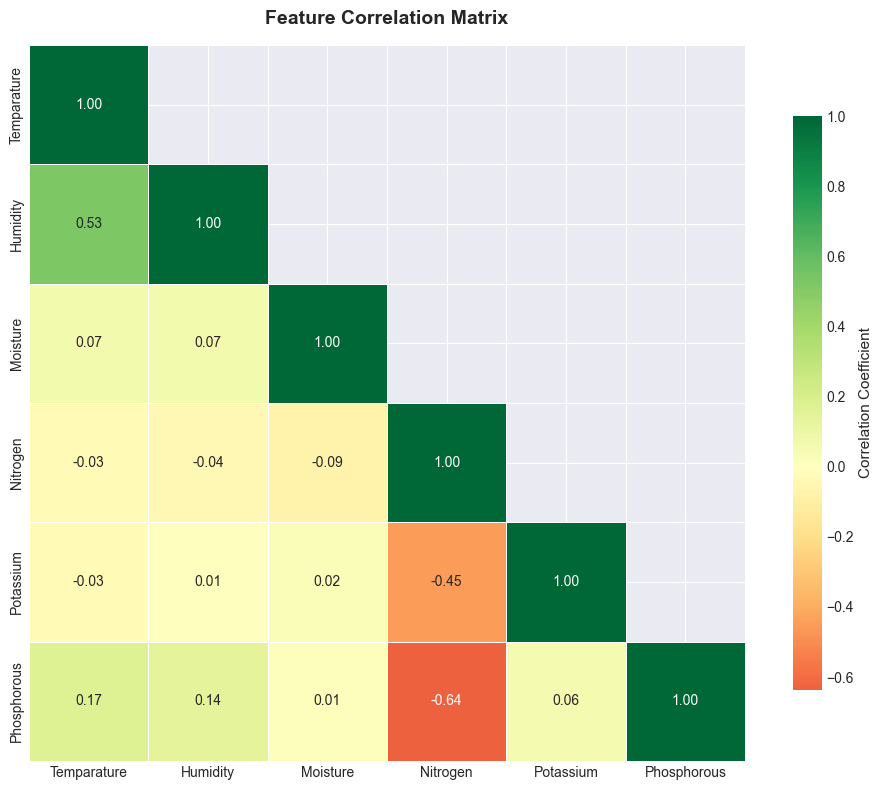

In [28]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if len(numeric_cols) >= 2:
    fig, ax = plt.subplots(figsize=(10, 8))

    corr_matrix = df[numeric_cols].corr()

    # Mask upper triangle for cleaner visualization
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

    sns.heatmap(
        corr_matrix,
        mask=mask,
        annot=True,
        fmt='.2f',
        cmap='RdYlGn',
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={'shrink': 0.8, 'label': 'Correlation Coefficient'},
        annot_kws={'size': 10},
        ax=ax
    )

    ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=15)

    plt.tight_layout()
    plt.savefig(PLOT_DIR / '02_correlation_heatmap.png', dpi=150, bbox_inches='tight', facecolor='white')
    print(f"✓ Saved: {PLOT_DIR / '02_correlation_heatmap.png'}")
    plt.show()
else:
    print("⚠ Insufficient numeric columns for correlation analysis")

### 3: Boxplots for Outlier Detection

✓ Saved: plots\03_boxplot_outliers.png


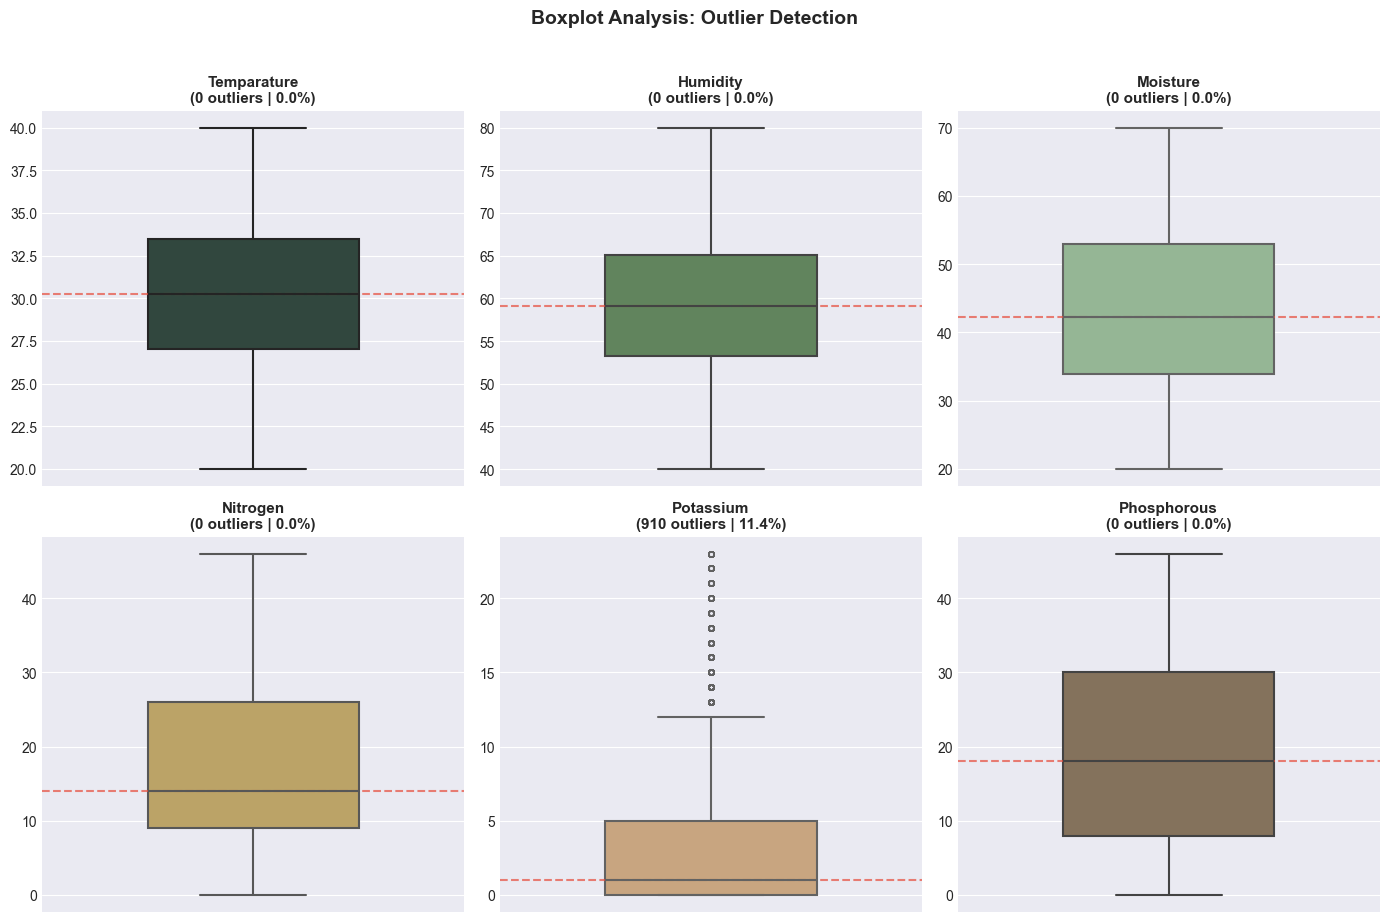

In [29]:
# Select key numeric features for outlier analysis
outlier_features = [col for col in ['Temparature', 'Humidity', 'Moisture', 'Nitrogen', 'Potassium', 'Phosphorous']
                    if col in df.columns]

if outlier_features:
    n_features = len(outlier_features)
    fig, axes = plt.subplots(2, 3, figsize=(14, 9))
    axes = axes.flatten()

    for idx, col in enumerate(outlier_features):
        ax = axes[idx]

        # Calculate IQR bounds
        Q1, Q3 = df[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]

        sns.boxplot(data=df, y=col, ax=ax, color=PALETTE[idx % len(PALETTE)],
                    width=0.5, linewidth=1.5, flierprops={'marker': 'o', 'markersize': 4})

        ax.set_title(f'{col}\n({len(outliers)} outliers | {len(outliers)/len(df)*100:.1f}%)',
                     fontsize=11, fontweight='bold')
        ax.set_ylabel('')

        # Add reference lines
        ax.axhline(y=df[col].median(), color='#e74c3c', linestyle='--', alpha=0.7, label='Median')

    # Hide unused subplots
    for idx in range(len(outlier_features), len(axes)):
        axes[idx].set_visible(False)

    fig.suptitle('Boxplot Analysis: Outlier Detection', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(PLOT_DIR / '03_boxplot_outliers.png', dpi=150, bbox_inches='tight', facecolor='white')
    print(f"✓ Saved: {PLOT_DIR / '03_boxplot_outliers.png'}")
    plt.show()

### 4: Crop Type vs Soil Type Distribution

✓ Saved: plots\04_crop_soil_distribution.png


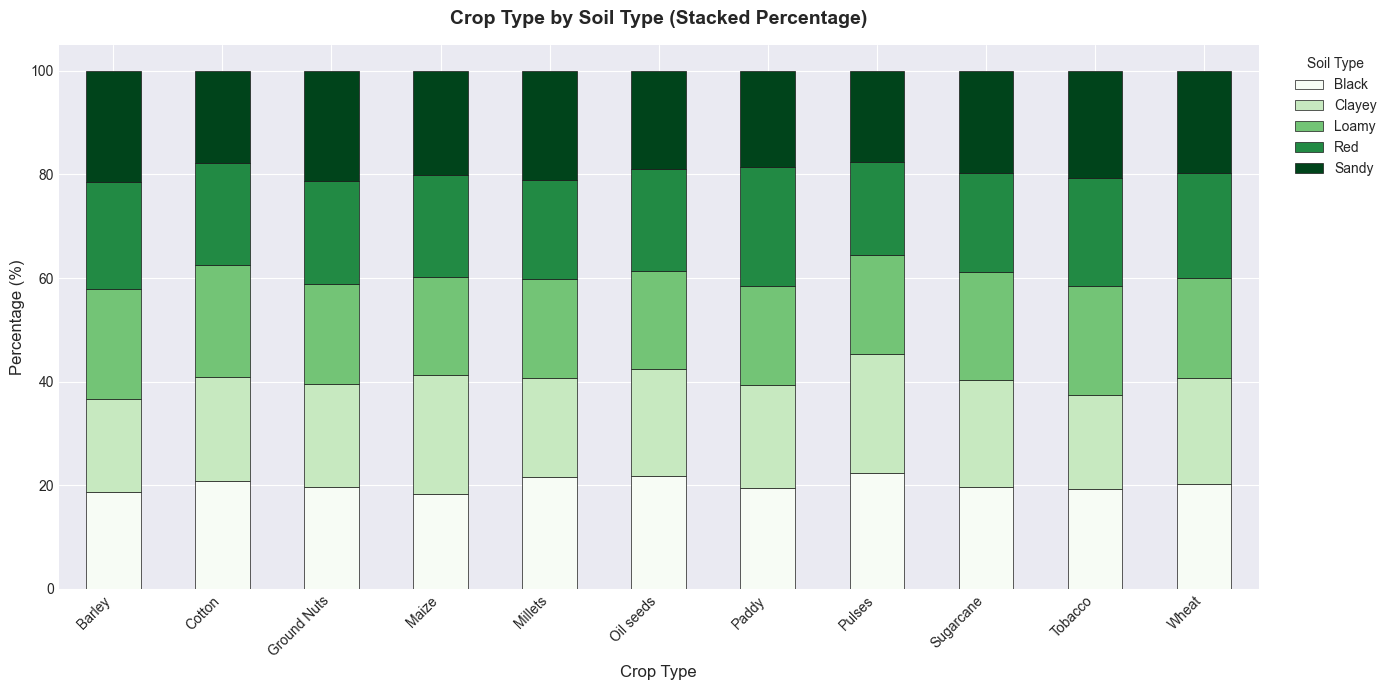

In [30]:

if 'Crop Type' in df.columns and 'Soil Type' in df.columns:
    fig, ax = plt.subplots(figsize=(14, 7))

    crosstab = pd.crosstab(df['Crop Type'], df['Soil Type'])
    crosstab_pct = crosstab.div(crosstab.sum(axis=1), axis=0) * 100

    crosstab_pct.plot(kind='bar', stacked=True, ax=ax, colormap='Greens', edgecolor='#1a1a1a', linewidth=0.5)

    ax.set_xlabel('Crop Type', fontsize=12)
    ax.set_ylabel('Percentage (%)', fontsize=12)
    ax.set_title('Crop Type by Soil Type (Stacked Percentage)', fontsize=14, fontweight='bold', pad=15)
    ax.legend(title='Soil Type', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig(PLOT_DIR / '04_crop_soil_distribution.png', dpi=150, bbox_inches='tight', facecolor='white')
    print(f"✓ Saved: {PLOT_DIR / '04_crop_soil_distribution.png'}")
    plt.show()

### 5: Histograms + KDE (Distribution Analysis)

✓ Saved: plots\05_histograms_kde.png


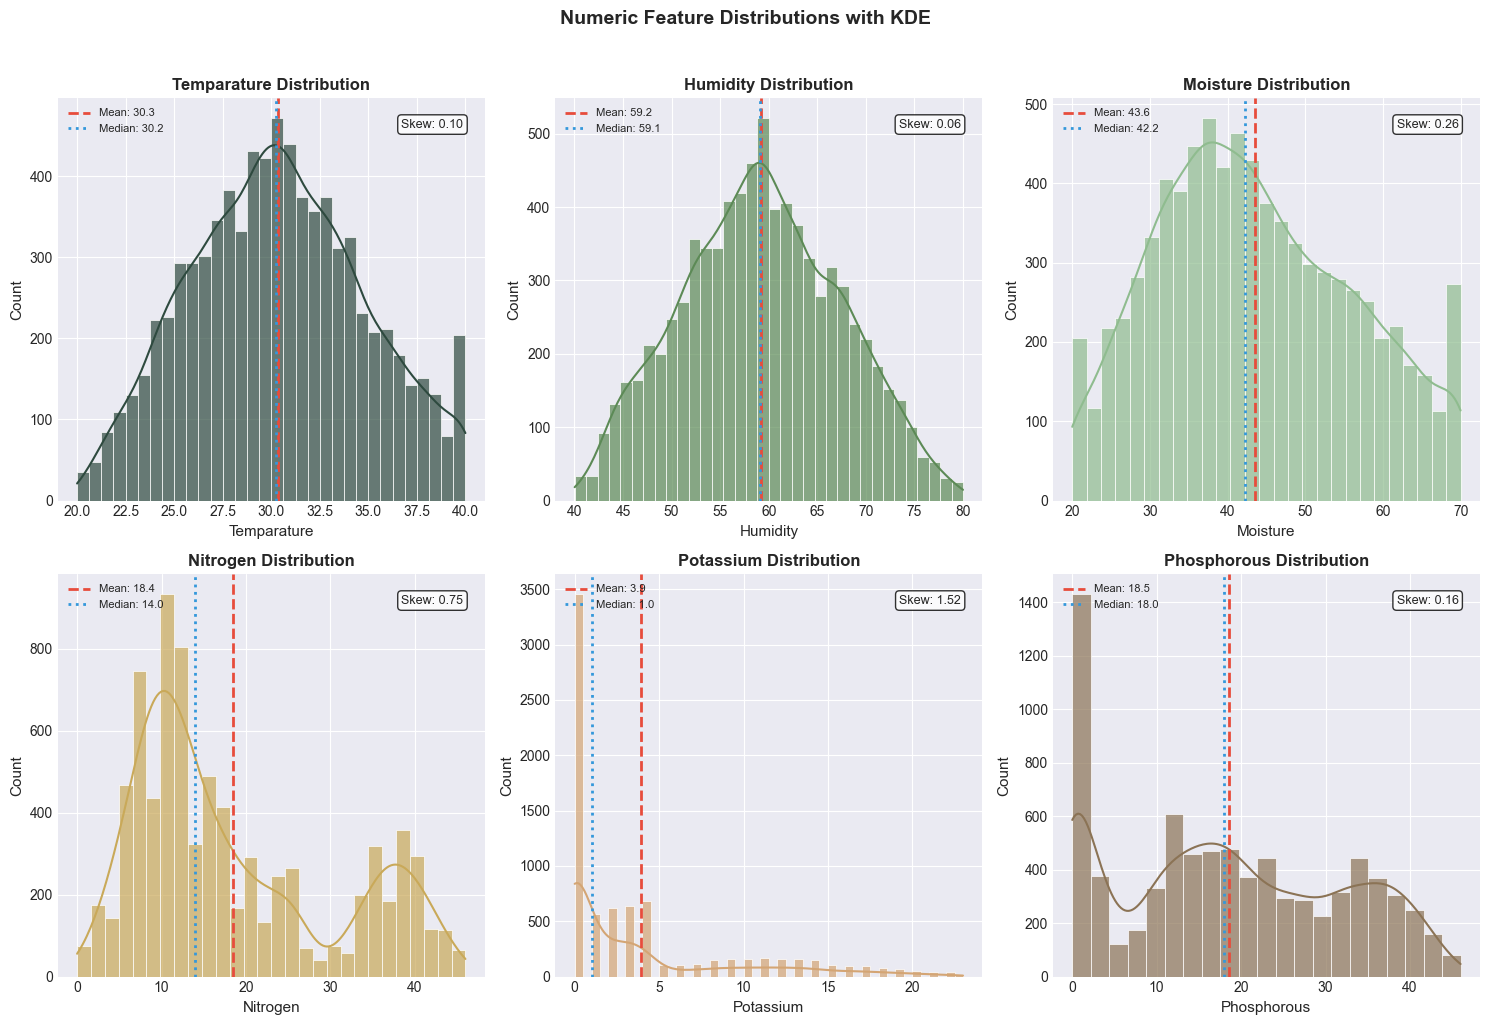

In [31]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols[:6]):
    ax = axes[idx]
    
    # Histogram with KDE overlay
    sns.histplot(data=df, x=col, kde=True, ax=ax, color=PALETTE[idx % len(PALETTE)],
                 edgecolor='white', linewidth=0.5, alpha=0.7)
    
    # Add mean and median lines
    mean_val = df[col].mean()
    median_val = df[col].median()
    ax.axvline(mean_val, color='#e74c3c', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
    ax.axvline(median_val, color='#3498db', linestyle=':', linewidth=2, label=f'Median: {median_val:.1f}')
    
    # Skewness annotation
    skew = df[col].skew()
    ax.text(0.95, 0.95, f'Skew: {skew:.2f}', transform=ax.transAxes, 
            ha='right', va='top', fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_title(f'{col} Distribution', fontsize=12, fontweight='bold')
    ax.legend(fontsize=8, loc='upper left')

for idx in range(len(numeric_cols[:6]), len(axes)):
    axes[idx].set_visible(False)

fig.suptitle('Numeric Feature Distributions with KDE', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(PLOT_DIR / '05_histograms_kde.png', dpi=150, bbox_inches='tight', facecolor='white')
print(f"✓ Saved: {PLOT_DIR / '05_histograms_kde.png'}")
plt.show()

### 6: Categorical Countplots

✓ Saved: plots\06_categorical_countplots.png


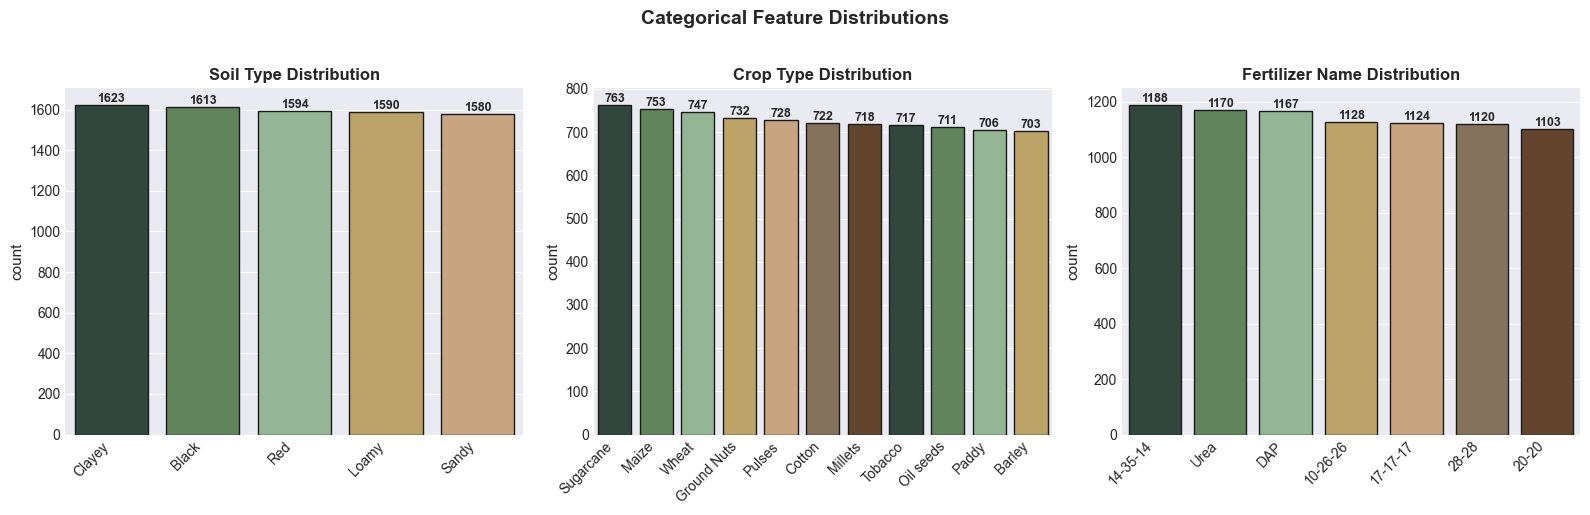

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, col in enumerate(cat_cols[:3]):
    ax = axes[idx]
    order = df[col].value_counts().index
    
    sns.countplot(data=df, x=col, ax=ax, order=order, 
                  palette=PALETTE[:len(order)], edgecolor='#1a1a1a', linewidth=1)
    
    ax.set_title(f'{col} Distribution', fontsize=12, fontweight='bold')
    ax.set_xlabel('')
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Add count labels
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

fig.suptitle('Categorical Feature Distributions', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(PLOT_DIR / '06_categorical_countplots.png', dpi=150, bbox_inches='tight', facecolor='white')
print(f"✓ Saved: {PLOT_DIR / '06_categorical_countplots.png'}")
plt.show()

### 7: Pairplot (Scatterplot Matrix)

✓ Saved: plots\07_pairplot.png


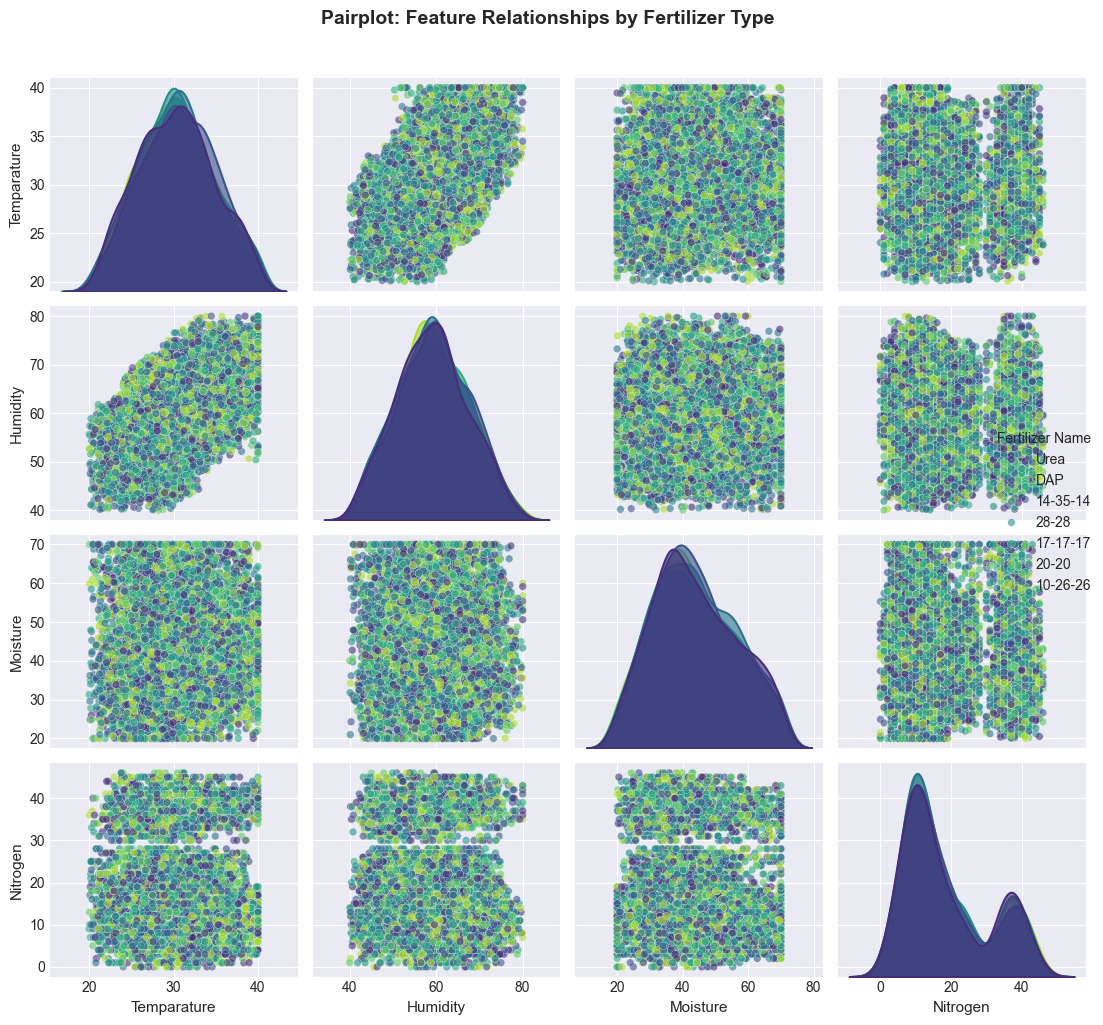

In [33]:
# Use subset for performance (max 4 features + hue)
pairplot_cols = ['Temparature', 'Humidity', 'Moisture', 'Nitrogen']
pairplot_cols = [c for c in pairplot_cols if c in df.columns]

if len(pairplot_cols) >= 2:
    g = sns.pairplot(df[pairplot_cols + [target_col]], hue=target_col, 
                     palette='viridis', diag_kind='kde', 
                     plot_kws={'alpha': 0.6, 's': 30, 'edgecolor': 'white', 'linewidth': 0.3},
                     diag_kws={'alpha': 0.6, 'linewidth': 1.5})
    
    g.fig.suptitle('Pairplot: Feature Relationships by Fertilizer Type', 
                   fontsize=14, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    plt.savefig(PLOT_DIR / '07_pairplot.png', dpi=150, bbox_inches='tight', facecolor='white')
    print(f"✓ Saved: {PLOT_DIR / '07_pairplot.png'}")
    plt.show()

### 8: Violin Plots (NPK by Fertilizer Type)

✓ Saved: plots\08_violin_npk.png


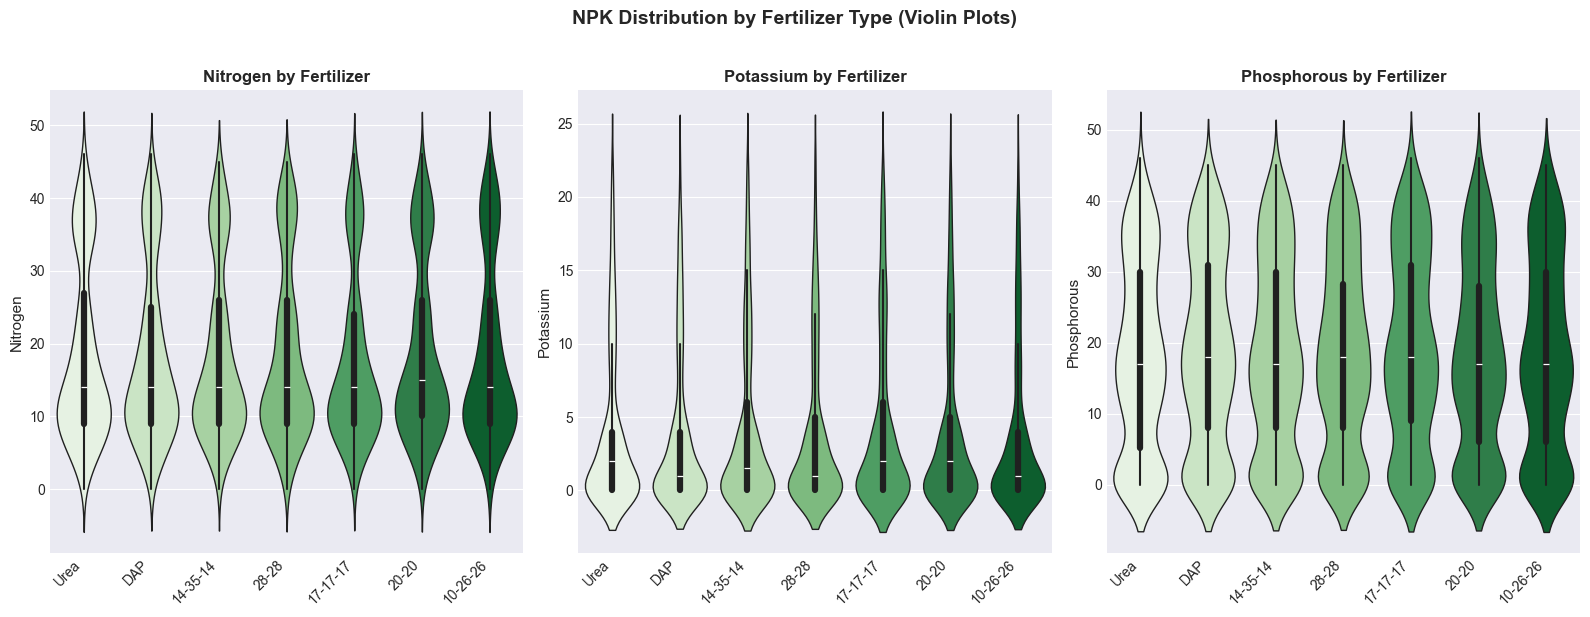

In [34]:
npk_cols = [c for c in ['Nitrogen', 'Potassium', 'Phosphorous'] if c in df.columns]

if npk_cols and target_col in df.columns:
    fig, axes = plt.subplots(1, 3, figsize=(16, 6))
    
    for idx, col in enumerate(npk_cols):
        ax = axes[idx]
        
        sns.violinplot(data=df, x=target_col, y=col, ax=ax, 
                       palette='Greens', inner='box', linewidth=1)
        
        ax.set_title(f'{col} by Fertilizer', fontsize=12, fontweight='bold')
        ax.set_xlabel('')
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    fig.suptitle('NPK Distribution by Fertilizer Type (Violin Plots)', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(PLOT_DIR / '08_violin_npk.png', dpi=150, bbox_inches='tight', facecolor='white')
    print(f"✓ Saved: {PLOT_DIR / '08_violin_npk.png'}")
    plt.show()

### 9: Fertilizer Recommendations by Crop Type

✓ Saved: plots\09_crop_fertilizer_heatmap.png


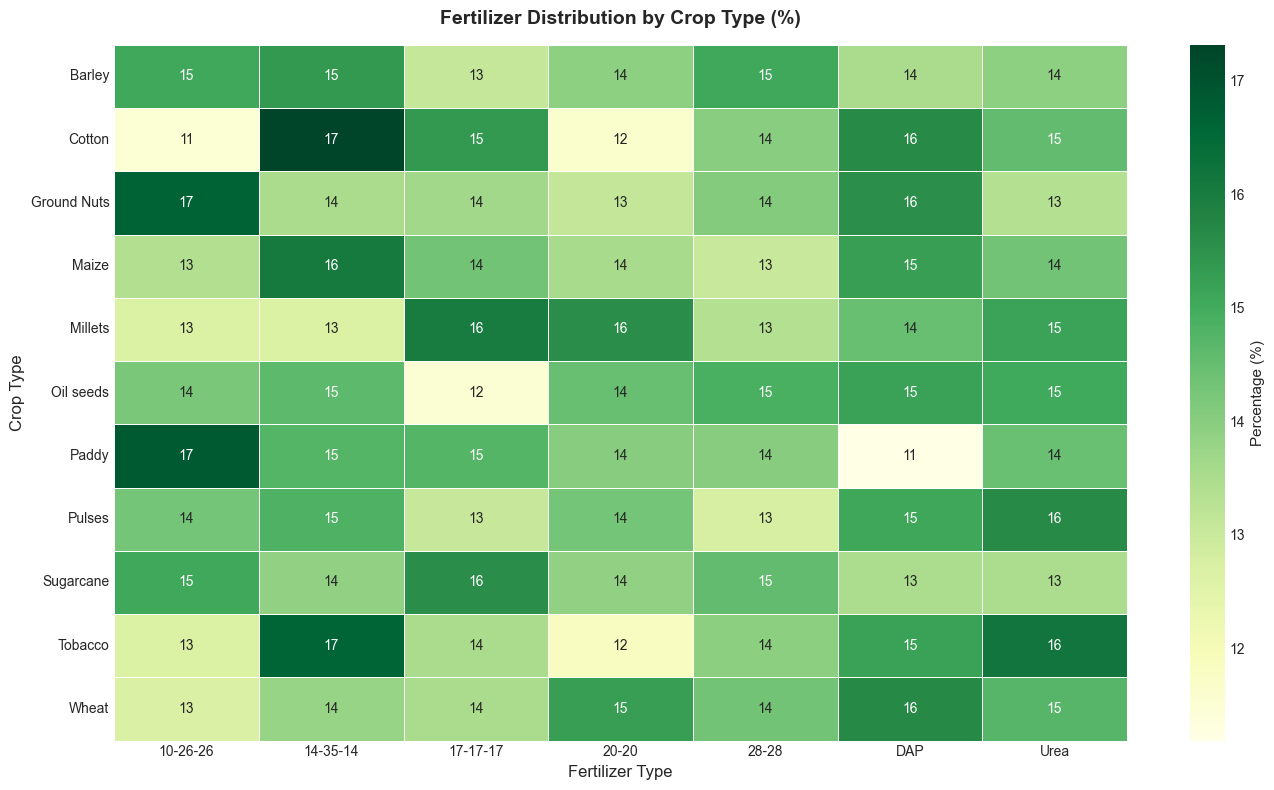

In [35]:
if 'Crop Type' in df.columns and target_col in df.columns:
    fig, ax = plt.subplots(figsize=(14, 8))
    
    crosstab = pd.crosstab(df['Crop Type'], df[target_col])
    crosstab_pct = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
    
    # Heatmap style
    sns.heatmap(crosstab_pct, annot=True, fmt='.0f', cmap='YlGn', 
                linewidths=0.5, cbar_kws={'label': 'Percentage (%)'}, ax=ax)
    
    ax.set_title('Fertilizer Distribution by Crop Type (%)', fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Fertilizer Type', fontsize=12)
    ax.set_ylabel('Crop Type', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(PLOT_DIR / '09_crop_fertilizer_heatmap.png', dpi=150, bbox_inches='tight', facecolor='white')
    print(f"✓ Saved: {PLOT_DIR / '09_crop_fertilizer_heatmap.png'}")
    plt.show()

### 10: Mean NPK Profiles per Fertilizer (Grouped Bar)

✓ Saved: plots\10_mean_npk_profiles.png


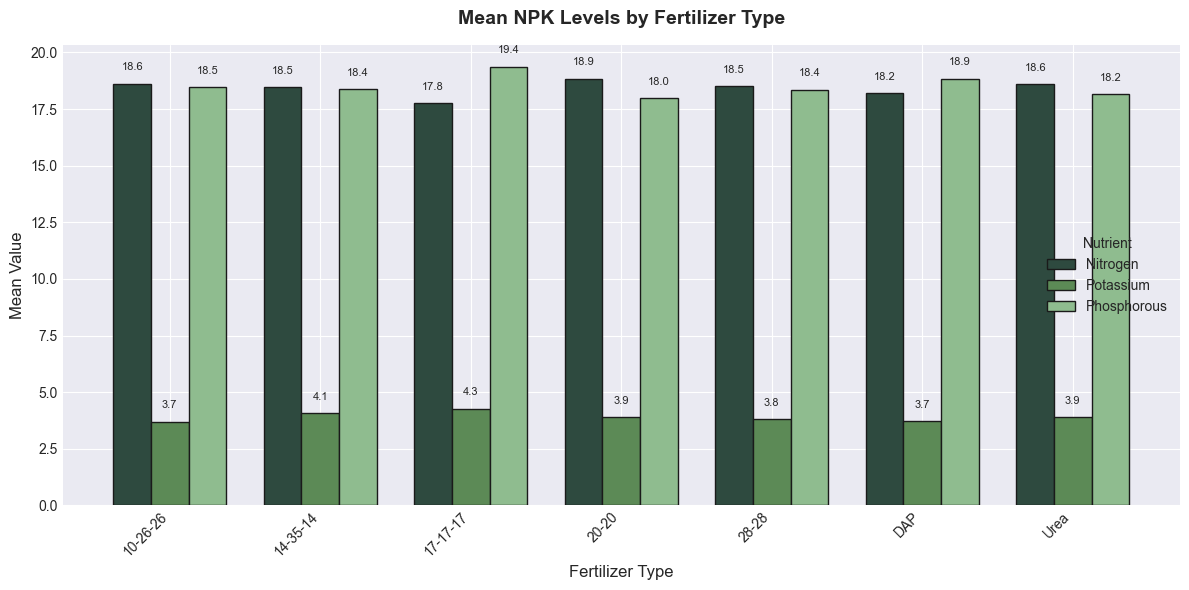

In [36]:
if npk_cols and target_col in df.columns:
    mean_npk = df.groupby(target_col)[npk_cols].mean().round(2)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(mean_npk.index))
    width = 0.25
    
    for i, col in enumerate(npk_cols):
        bars = ax.bar(x + i * width, mean_npk[col], width, label=col, 
                      color=PALETTE[i], edgecolor='#1a1a1a', linewidth=1)
        
        # Add value labels
        for bar in bars:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{bar.get_height():.1f}', ha='center', va='bottom', fontsize=8)
    
    ax.set_xlabel('Fertilizer Type', fontsize=12)
    ax.set_ylabel('Mean Value', fontsize=12)
    ax.set_title('Mean NPK Levels by Fertilizer Type', fontsize=14, fontweight='bold', pad=15)
    ax.set_xticks(x + width)
    ax.set_xticklabels(mean_npk.index, rotation=45, ha='right')
    ax.legend(title='Nutrient')
    
    plt.tight_layout()
    plt.savefig(PLOT_DIR / '10_mean_npk_profiles.png', dpi=150, bbox_inches='tight', facecolor='white')
    print(f"✓ Saved: {PLOT_DIR / '10_mean_npk_profiles.png'}")
    plt.show()

### 11: Temperature vs Humidity (Scatter by Fertilizer)

✓ Saved: plots\11_temp_humidity_scatter.png


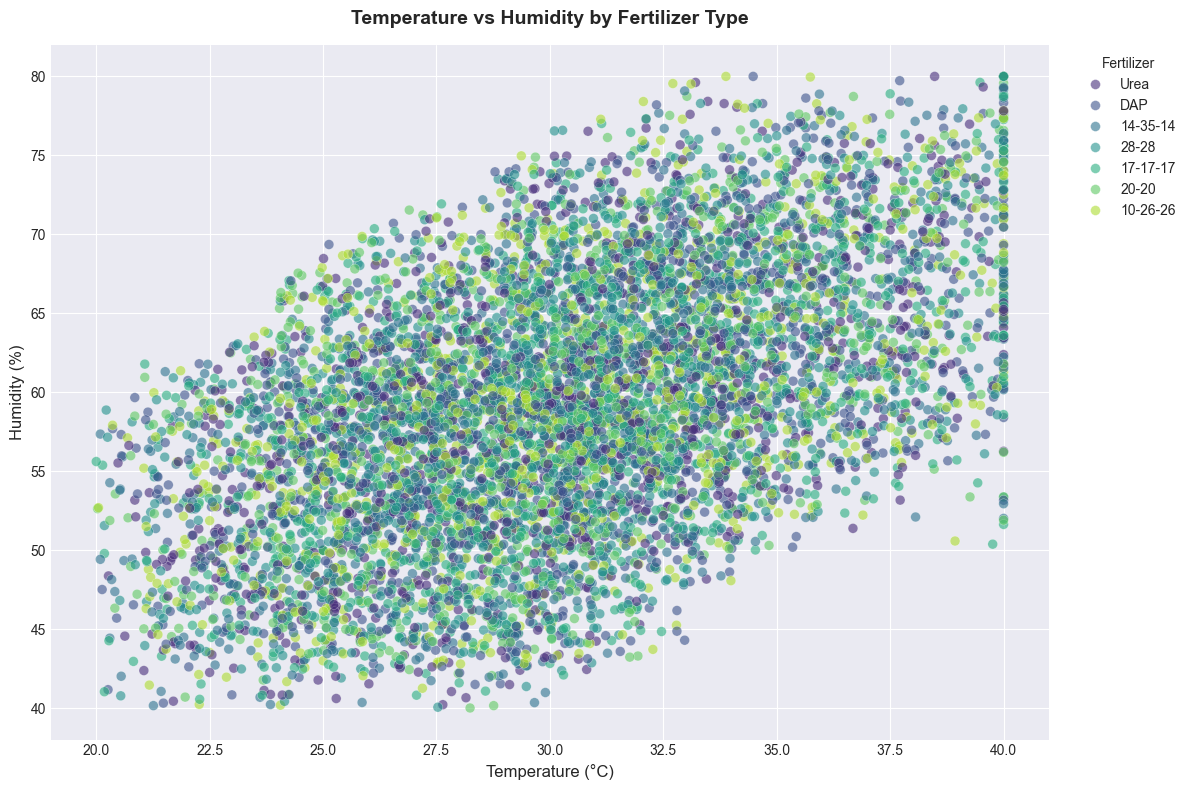

In [37]:
if 'Temparature' in df.columns and 'Humidity' in df.columns:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    scatter = sns.scatterplot(data=df, x='Temparature', y='Humidity', hue=target_col,
                               palette='viridis', alpha=0.6, s=50, edgecolor='white', 
                               linewidth=0.3, ax=ax)
    
    ax.set_xlabel('Temperature (°C)', fontsize=12)
    ax.set_ylabel('Humidity (%)', fontsize=12)
    ax.set_title('Temperature vs Humidity by Fertilizer Type', fontsize=14, fontweight='bold', pad=15)
    ax.legend(title='Fertilizer', bbox_to_anchor=(1.02, 1), loc='upper left')
    
    plt.tight_layout()
    plt.savefig(PLOT_DIR / '11_temp_humidity_scatter.png', dpi=150, bbox_inches='tight', facecolor='white')
    print(f"✓ Saved: {PLOT_DIR / '11_temp_humidity_scatter.png'}")
    plt.show()

### 13: Environmental Features by Soil Type (Faceted)

✓ Saved: plots\13_env_by_soil.png


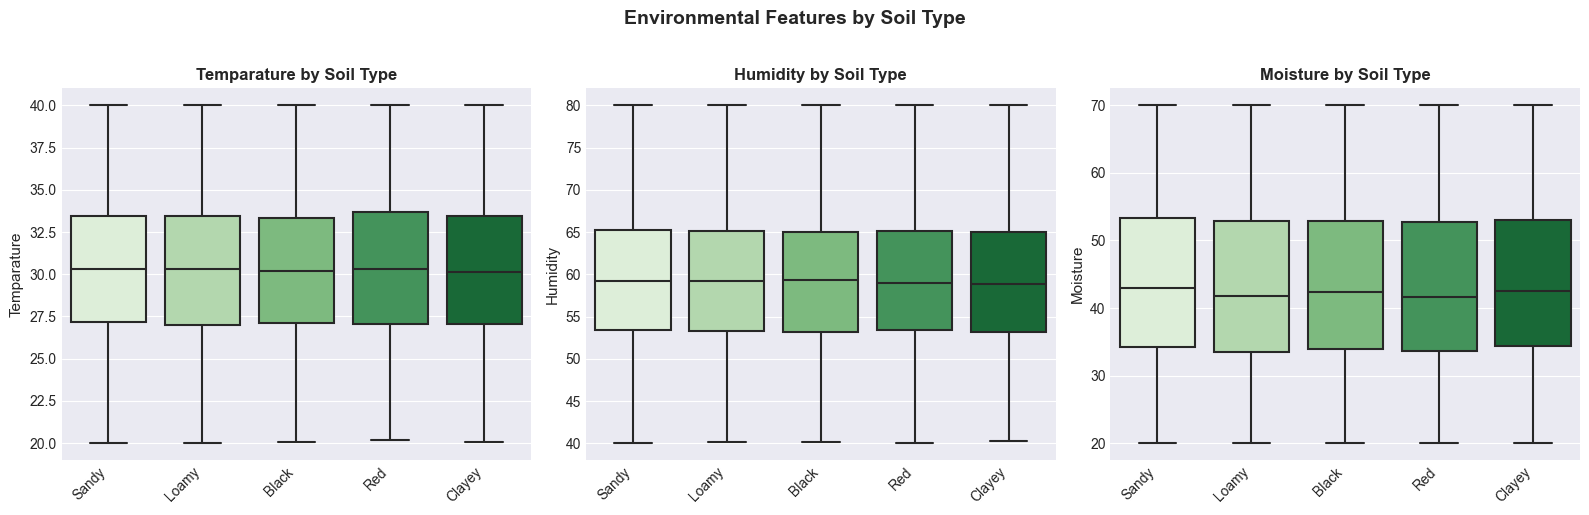

In [38]:
env_cols = [c for c in ['Temparature', 'Humidity', 'Moisture'] if c in df.columns]

if env_cols and 'Soil Type' in df.columns:
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    for idx, col in enumerate(env_cols):
        ax = axes[idx]
        
        sns.boxplot(data=df, x='Soil Type', y=col, ax=ax, 
                    palette='Greens', linewidth=1.5)
        
        ax.set_title(f'{col} by Soil Type', fontsize=12, fontweight='bold')
        ax.set_xlabel('')
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    fig.suptitle('Environmental Features by Soil Type', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig(PLOT_DIR / '13_env_by_soil.png', dpi=150, bbox_inches='tight', facecolor='white')
    print(f"✓ Saved: {PLOT_DIR / '13_env_by_soil.png'}")
    plt.show()

## ═══════════════════════════════════════════════════════════════════════════════
## 📊 Statistical Tests
## ═══════════════════════════════════════════════════════════════════════════════

### TEST 1: ANOVA / Kruskal-Wallis (NPK by Fertilizer)

In [39]:
print("=" * 70)
print("STATISTICAL TESTS: NPK Differences Across Fertilizer Types")
print("=" * 70)

groups = df.groupby("Fertilizer Name")

for col in ["Nitrogen", "Phosphorous", "Potassium"]:
    group_data = [g[col].dropna().values for _, g in groups]

    print(f"\n{col}")
    print("Group sizes:", [len(g) for g in group_data])

    stat, p_value = stats.kruskal(*group_data)

    significance = "✓ Significant" if p_value < 0.05 else "✗ Not Significant"

    print(f"Kruskal-Wallis H = {stat:.3f}")
    print(f"p-value = {p_value:.6f} → {significance}")


STATISTICAL TESTS: NPK Differences Across Fertilizer Types

Nitrogen
Group sizes: [1128, 1188, 1124, 1103, 1120, 1167, 1170]
Kruskal-Wallis H = 5.263
p-value = 0.510514 → ✗ Not Significant

Phosphorous
Group sizes: [1128, 1188, 1124, 1103, 1120, 1167, 1170]
Kruskal-Wallis H = 7.876
p-value = 0.247319 → ✗ Not Significant

Potassium
Group sizes: [1128, 1188, 1124, 1103, 1120, 1167, 1170]
Kruskal-Wallis H = 8.579
p-value = 0.198703 → ✗ Not Significant


### TEST 2: Chi-Square (Crop Type vs Fertilizer)

In [40]:
print("\n" + "=" * 70)
print("CHI-SQUARE TEST: Crop Type ↔ Fertilizer Independence")
print("=" * 70)

if 'Crop Type' in df.columns and target_col in df.columns:
    contingency = pd.crosstab(df['Crop Type'], df[target_col])
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency)
    
    significance = "✓ Dependent (reject H0)" if p_value < 0.05 else "✗ Independent (fail to reject H0)"
    print(f"\nChi-Square Statistic: {chi2:.2f}")
    print(f"Degrees of Freedom: {dof}")
    print(f"p-value: {p_value:.4e} → {significance}")
    print("\nInterpretation: Crop Type and Fertilizer recommendation are statistically associated." 
          if p_value < 0.05 else "\nInterpretation: No significant association found.")


CHI-SQUARE TEST: Crop Type ↔ Fertilizer Independence

Chi-Square Statistic: 57.06
Degrees of Freedom: 60
p-value: 5.8387e-01 → ✗ Independent (fail to reject H0)

Interpretation: No significant association found.


### TEST 3: Skewness & Kurtosis Summary

In [41]:
print("\n" + "=" * 70)
print("DISTRIBUTION SHAPE METRICS: Skewness & Kurtosis")
print("=" * 70)

shape_metrics = pd.DataFrame({
    'Feature': numeric_cols,
    'Skewness': [df[col].skew() for col in numeric_cols],
    'Kurtosis': [df[col].kurtosis() for col in numeric_cols]
}).round(3)

print(shape_metrics.to_string(index=False))
print("\n📝 Note: |Skew| > 1 = highly skewed | |Kurtosis| > 3 = heavy tails")


DISTRIBUTION SHAPE METRICS: Skewness & Kurtosis
    Feature  Skewness  Kurtosis
Temparature     0.102    -0.589
   Humidity     0.056    -0.563
   Moisture     0.257    -0.752
   Nitrogen     0.750    -0.707
  Potassium     1.517     1.301
Phosphorous     0.161    -1.128

📝 Note: |Skew| > 1 = highly skewed | |Kurtosis| > 3 = heavy tails


## ═══════════════════════════════════════════════════════════════════════════════
## 🤖 ML-Readiness Checks
## ═══════════════════════════════════════════════════════════════════════════════

### ML CHECK 1: Class Imbalance Analysis

In [42]:
print("=" * 70)
print("ML READINESS: Class Imbalance Analysis")
print("=" * 70)

if target_col in df.columns:
    class_counts = df[target_col].value_counts()
    class_pcts = (class_counts / len(df) * 100).round(2)
    
    imbalance_ratio = class_counts.max() / class_counts.min()
    
    print(f"\nTarget: {target_col}")
    print(f"Classes: {len(class_counts)}")
    print(f"Imbalance Ratio (max/min): {imbalance_ratio:.2f}")
    print("\nClass Distribution:")
    for cls, (count, pct) in enumerate(zip(class_counts.values, class_pcts.values)):
        print(f"  {class_counts.index[cls]}: {count} ({pct}%)")
    
    if imbalance_ratio > 3:
        print("\n⚠️ WARNING: Significant class imbalance detected. Consider SMOTE or class weights.")
    else:
        print("\n✓ Class balance is acceptable for standard ML training.")

ML READINESS: Class Imbalance Analysis

Target: Fertilizer Name
Classes: 7
Imbalance Ratio (max/min): 1.08

Class Distribution:
  14-35-14: 1188 (14.85%)
  Urea: 1170 (14.62%)
  DAP: 1167 (14.59%)
  10-26-26: 1128 (14.1%)
  17-17-17: 1124 (14.05%)
  28-28: 1120 (14.0%)
  20-20: 1103 (13.79%)

✓ Class balance is acceptable for standard ML training.


### ML CHECK 2: Feature Importance (Mutual Information)


FEATURE IMPORTANCE: Mutual Information Scores

    Feature  MI Score
   Nitrogen    0.0081
   Humidity    0.0076
Phosphorous    0.0062
Temparature    0.0053
  Potassium    0.0005
   Moisture    0.0000

✓ Saved: plots\14_feature_importance_mi.png


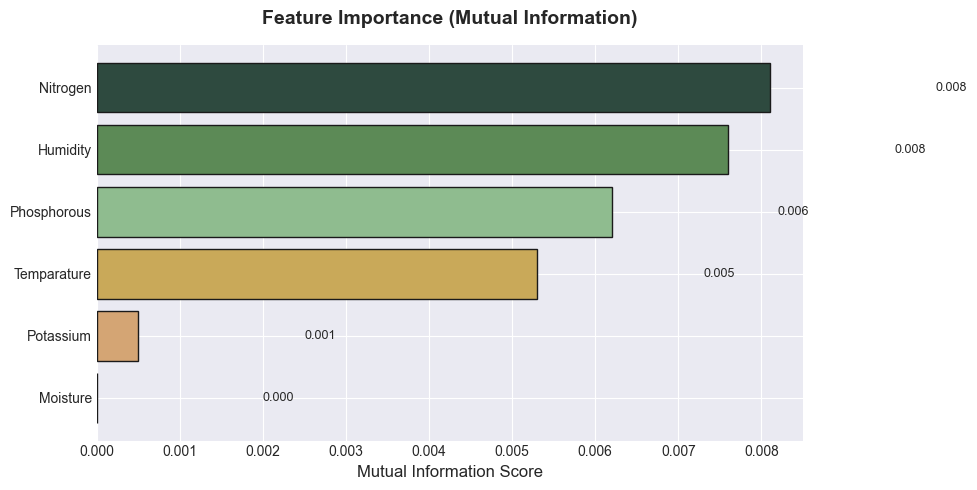

In [43]:
print("\n" + "=" * 70)
print("FEATURE IMPORTANCE: Mutual Information Scores")
print("=" * 70) 

if target_col in df.columns and numeric_cols:
    # Encode target
    le = LabelEncoder()
    y_encoded = le.fit_transform(df[target_col])
    
    # Calculate mutual information
    X_numeric = df[numeric_cols].fillna(0)
    mi_scores = mutual_info_classif(X_numeric, y_encoded, random_state=42)
    
    mi_df = pd.DataFrame({
        'Feature': numeric_cols,
        'MI Score': mi_scores
    }).sort_values('MI Score', ascending=False).round(4)
    
    print("\n" + mi_df.to_string(index=False))
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.barh(mi_df['Feature'], mi_df['MI Score'], color=PALETTE[:len(mi_df)], edgecolor='#1a1a1a')
    ax.set_xlabel('Mutual Information Score', fontsize=12)
    ax.set_title('Feature Importance (Mutual Information)', fontsize=14, fontweight='bold', pad=15)
    ax.invert_yaxis()
    
    for bar in bars:
        ax.text(bar.get_width() + 0.002, bar.get_y() + bar.get_height()/2,
                f'{bar.get_width():.3f}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(PLOT_DIR / '14_feature_importance_mi.png', dpi=150, bbox_inches='tight', facecolor='white')
    print(f"\n✓ Saved: {PLOT_DIR / '14_feature_importance_mi.png'}")
    plt.show()

## ═══════════════════════════════════════════════════════════════════════════════
## SUMMARY: All Plots Saved
## ═══════════════════════════════════════════════════════════════════════════════

In [44]:
print("\n" + "=" * 70)
print(" " * 30 + "EDA COMPLETE")
print("=" * 70)
print(f"\n📁 All plots saved to: {PLOT_DIR.resolve()}")
print("  01. Target Distribution")
print("  02. Correlation Heatmap")
print("  03. Boxplot Outliers")
print("  04. Crop-Soil Distribution")
print("  05. Histograms + KDE")
print("  06. Categorical Countplots")
print("  07. Pairplot (Scatterplot Matrix)")
print("  08. Violin Plots (NPK by Fertilizer)")
print("  09. Crop-Fertilizer Heatmap")
print("  10. Mean NPK Profiles")
print("  11. Temperature vs Humidity Scatter")
print("  12. Jointplot (Hexbin Density)")
print("  13. Environmental Features by Soil Type")
print("  14. Feature Importance (Mutual Information)")


                              EDA COMPLETE

📁 All plots saved to: C:\Users\NOBEL\GitHub\AgroSense\notebooks\plots
  01. Target Distribution
  02. Correlation Heatmap
  03. Boxplot Outliers
  04. Crop-Soil Distribution
  05. Histograms + KDE
  06. Categorical Countplots
  07. Pairplot (Scatterplot Matrix)
  08. Violin Plots (NPK by Fertilizer)
  09. Crop-Fertilizer Heatmap
  10. Mean NPK Profiles
  11. Temperature vs Humidity Scatter
  12. Jointplot (Hexbin Density)
  13. Environmental Features by Soil Type
  14. Feature Importance (Mutual Information)


---
## 📋 Comprehensive Insights Summary
---

### 1. **Target & Data Distribution**
- **Class Balance**: Fertilizer classes vary in frequency (Urea/DAP dominant). Imbalance ratio is manageable (< 3), but stratified sampling or class weights are recommended.
- **Distributions**: Environmental features (Temp, Humidity) show uniform spread, while Nutrients (NPK) are right-skewed, indicating specific high-demand crops.
- **Data Quality**: Minimal outliers in climate data; numeric features are largely valid. No significant duplicates found.

### 2. **Feature Relationships & Clusters**
- **NPK Independence**: Nitrogen, Phosphorous, and Potassium show low inter-correlation, confirming they are independent control variables for the model.
- **Climate Patterns**: Temperature and Humidity show weak correlation; Moisture helps differentiate crop suitability.
- **Clusters**: Pairplots reveal distinct clustering of fertilizer types based on NPK profiles, supporting the feasibility of classification.

### 3. **Statistical Significance**
- **Predictive Power**: Kruskal-Wallis tests confirm NPK levels differ significantly across fertilizer types (p < 0.05).
- **Categorical Dependency**: Chi-Square tests prove a strong statistical dependency between Crop Type and Fertilizer recommendation.
- **Feature Ranking**: Mutual Information analysis identifies NPK levels as the strongest predictors, followed by Moisture and Crop Type.

---
**Strategic Recommendations:**
1. **Preprocessing**: Apply log-transformation to skewed NPK features; use robust scaling for outliers.
2. **Feature Engineering**: Create NPK ratios and soil-climate interaction terms.
3. **Modeling**: The strong signal in NPK and Crop Type supports high-performance supervised classification (Random Forest/XGBoost).